# <p style="text-align: center;">A first simple LSTM network<br>for time series prediction
</p>

<p style="text-align: center;">
 by Prof. Dr.-Ing. Jürgen Brauer, http://www.juergenbrauer.org
</p>

## Table of Contents:

1. Generate some time series data
2. Plot the time series data
3. Prepare training data
4. Building and training the LSTM network model using Keras
5. Test prediction performance on train data
6. Experiments regarding LOOK_BACK and NR_TRAIN_EPOCHS
7. Long-term predictions
8. Experiments with long-term predictions

## 1. Generate some time series data

In [124]:
# Experiment settings:
# Set EXP_NR to one of the following values: 1-6
EXP_NR = 6
print("Using settings for EXP_NR", EXP_NR)

if EXP_NR==1:
    LOOK_BACK = 3
    NR_LSTM_CELLS = 8
    NR_TRAIN_EPOCHS = 500
    SCALE_TIME_SERIES = True
    MORE_DATA = 1.0
    
if EXP_NR==2:
    LOOK_BACK = 3
    NR_LSTM_CELLS = 8
    NR_TRAIN_EPOCHS = 1500
    SCALE_TIME_SERIES = True
    MORE_DATA = 1.0
    
if EXP_NR==3:
    LOOK_BACK = 6
    NR_LSTM_CELLS = 8
    NR_TRAIN_EPOCHS = 1500
    SCALE_TIME_SERIES = True
    MORE_DATA = 5.0
    
if EXP_NR==4:
    LOOK_BACK = 6
    NR_LSTM_CELLS = 8
    NR_TRAIN_EPOCHS = 1500
    SCALE_TIME_SERIES = False
    MORE_DATA = 5.0

if EXP_NR==5:
    LOOK_BACK = 20
    NR_LSTM_CELLS = 8
    NR_TRAIN_EPOCHS = 1500
    SCALE_TIME_SERIES = True
    MORE_DATA = 5.0
    
if EXP_NR==6:
    LOOK_BACK = 20
    NR_LSTM_CELLS = 32
    NR_TRAIN_EPOCHS = 3000
    SCALE_TIME_SERIES = True
    MORE_DATA = 5.0

    
import numpy as np
from sklearn.preprocessing import MinMaxScaler

data_x = [x for x in np.arange(0,MORE_DATA*6*np.pi, np.pi/8)]
print("Length of data_x is", len(data_x))

# test time series #1
# cos(x): a periodic time series
#time_series = [np.cos(x) for x in data_x]

# test time series #2
# x/10.0+cos(x): i.e. time series has an underlying trend
#time_series = [x/10.0+np.cos(x) for x in data_x]

# test time series #3
# x+cos(x): i.e. time series has an underlying trend
time_series = [x+np.cos(x) for x in data_x]

if SCALE_TIME_SERIES:
    
    # Rescale time series such that values are in [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_time_series = scaler.fit_transform(np.array(time_series).reshape(-1,1))
    scaled_time_series = scaled_time_series.reshape(-1).tolist()
    time_series = scaled_time_series


print("Length of time_series is", len(time_series))
print("time_series=", time_series)


Using settings for EXP_NR 6
Length of data_x is 240
Length of time_series is 240
time_series= [0.0, 0.0033757957436562035, 0.005251763767445643, 0.005979813351645243, 0.006086613953052914, 0.006193414554460585, 0.0069214641386601845, 0.008797432162449622, 0.012173227906105826, 0.017172425475528143, 0.02367145076481722, 0.03131839449369613, 0.039586587205366994, 0.04785477991703785, 0.05550172364591676, 0.06200074893520583, 0.06699994650462815, 0.07037574224828437, 0.0722517102720738, 0.0729797598562734, 0.07308656045768107, 0.07319336105908875, 0.07392141064328833, 0.07579737866707778, 0.07917317441073399, 0.08417237198015631, 0.09067139726944538, 0.09831834099832427, 0.10658653370999514, 0.114854726421666, 0.12250167015054489, 0.129000695439834, 0.13399989300925633, 0.1373756887529125, 0.13925165677670198, 0.13997970636090157, 0.14008650696230923, 0.1401933075637169, 0.1409213571479165, 0.14279732517170593, 0.14617312091536214, 0.15117231848478443, 0.15767134377407355, 0.1653182875029

## 2. Plot the time series data

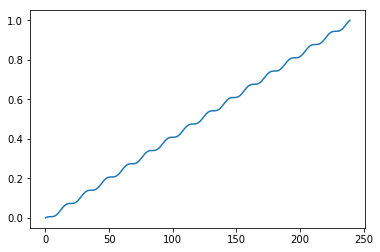

In [125]:
import matplotlib.pyplot as plt
plt.plot(time_series)
plt.show()

## 3. Prepare training data

For the training of the LSTM we need training samples of the form

    [value_t-2, value_t-1, value_t  ] --> value_t+1
    [value_t-1, value_t  , value_t+1] --> value_t+2
    [value_t  , value_t+1, value_t+2] --> value_t+3
    ...
    etc.


In [126]:
# define a helper function to convert a time series array
# into two NumPy arrays
# train_input (containing LOOK_BACK samples)
# and
# train_output (containing 1 prediction sample)

def split_into_train_samples(dataset, LOOK_BACK=1):
   train_input, train_output = [], []
   for i in range(len(dataset)-LOOK_BACK):
      a = dataset[i:i+LOOK_BACK]
      train_input.append(a)
      train_output.append(dataset[i + LOOK_BACK])
   return np.array(train_input), np.array(train_output)


# define how NumPy shall print matrices
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True) # do not use scientific "e"-notation

train_input, train_output = split_into_train_samples( time_series, LOOK_BACK)
print("train_input has shape", train_input.shape)
print("train_output has shape", train_output.shape)
print("train_input=", train_input)
print("train_output=", train_output)


train_input has shape (220, 20)
train_output has shape (220,)
train_input= [[0.   0.   0.01 ... 0.07 0.07 0.07]
 [0.   0.01 0.01 ... 0.07 0.07 0.07]
 [0.01 0.01 0.01 ... 0.07 0.07 0.07]
 ...
 [0.89 0.89 0.9  ... 0.96 0.97 0.98]
 [0.89 0.9  0.91 ... 0.97 0.98 0.99]
 [0.9  0.91 0.92 ... 0.98 0.99 0.99]]
train_output= [0.07 0.07 0.07 0.08 0.08 0.08 0.09 0.1  0.11 0.11 0.12 0.13 0.13 0.14
 0.14 0.14 0.14 0.14 0.14 0.14 0.15 0.15 0.16 0.17 0.17 0.18 0.19 0.2
 0.2  0.2  0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.22 0.22 0.23 0.24 0.25
 0.26 0.26 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.28 0.28 0.29 0.29 0.3
 0.31 0.32 0.32 0.33 0.33 0.34 0.34 0.34 0.34 0.34 0.34 0.34 0.35 0.35
 0.36 0.37 0.37 0.38 0.39 0.4  0.4  0.41 0.41 0.41 0.41 0.41 0.41 0.41
 0.41 0.42 0.43 0.43 0.44 0.45 0.46 0.46 0.47 0.47 0.47 0.47 0.48 0.48
 0.48 0.48 0.48 0.49 0.49 0.5  0.51 0.52 0.52 0.53 0.54 0.54 0.54 0.54
 0.54 0.54 0.54 0.54 0.55 0.55 0.56 0.57 0.58 0.58 0.59 0.6  0.6  0.61
 0.61 0.61 0.61 0.61 0.61 0.61 0.62 0.62 0.63 

## 4. Building and training the LSTM network model using Keras

Preparing the input to a LSTM can be a little bit tricky!

However, Jason Brownlee has a blog which provides a
gentle introduction into the topic:

"The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

    - Samples. One sequence is one sample. A batch is comprised of one or more samples.
    - Time Steps. One time step is one point of observation in the sample.
    - Features. One feature is one observation at a time step.
    
When defining the input layer of your LSTM network,
the network assumes you have 1 or more samples and
requires that you specify the number of time steps and
the number of features. You can do this by specifying
a tuple to the “input_shape” argument.

For example, the model below defines an input layer
that expects 1 or more samples, 50 time steps, and 2 features.

    model = Sequential()
    model.add(LSTM(32, input_shape=(50, 2)))
    model.add(Dense(1))"

Quotation source:
https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

In [127]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# 1.
# Configure LSTM model & training
BATCH_SIZE = train_input.shape[0]

# 2.
# Prepare training data for the Keras LSTM model
# Keras expects LSTM input to be 3-dimensional!
# Should have shape: [nr of samples, nr of time steps, nr of features]
#
train_input_reshaped  = train_input.reshape( (train_input.shape[0], LOOK_BACK, 1) )
print("Shape of train_input_reshaped is", train_input_reshaped.shape)
#print("train_input_reshaped=", train_input_reshaped)

# 3.
# Build the LSTM model using Keras
model = Sequential()
model.add( LSTM(NR_LSTM_CELLS, input_shape = (LOOK_BACK,1)) )
model.add( Dense(1) )
model.compile(loss='mean_squared_error', optimizer='sgd')

# 4.
# Train the LSTM model
model.fit(train_input_reshaped,
          train_output,
          batch_size=BATCH_SIZE,
          shuffle=False,          
          epochs=NR_TRAIN_EPOCHS)

Shape of train_input_reshaped is (220, 20, 1)
Epoch 1/3000
220/220 [==============================] - 1s 6ms/step - loss: 0.4387
Epoch 2/3000
220/220 [==============================] - 0s 52us/step - loss: 0.3926
Epoch 3/3000
220/220 [==============================] - 0s 50us/step - loss: 0.3519
Epoch 4/3000
220/220 [==============================] - 0s 55us/step - loss: 0.3160
Epoch 5/3000
220/220 [==============================] - 0s 52us/step - loss: 0.2842
Epoch 6/3000
220/220 [==============================] - 0s 52us/step - loss: 0.2562
Epoch 7/3000
220/220 [==============================] - 0s 57us/step - loss: 0.2314
Epoch 8/3000
220/220 [==============================] - 0s 57us/step - loss: 0.2094
Epoch 9/3000
220/220 [==============================] - 0s 52us/step - loss: 0.1900
Epoch 10/3000
220/220 [==============================] - 0s 57us/step - loss: 0.1728
Epoch 11/3000
220/220 [==============================] - 0s 52us/step - loss: 0.1576
Epoch 12/3000
220/220 [======

Epoch 97/3000
220/220 [==============================] - 0s 57us/step - loss: 0.0310
Epoch 98/3000
220/220 [==============================] - 0s 61us/step - loss: 0.0308
Epoch 99/3000
220/220 [==============================] - 0s 64us/step - loss: 0.0306
Epoch 100/3000
220/220 [==============================] - 0s 64us/step - loss: 0.0305
Epoch 101/3000
220/220 [==============================] - 0s 61us/step - loss: 0.0303
Epoch 102/3000
220/220 [==============================] - 0s 59us/step - loss: 0.0301
Epoch 103/3000
220/220 [==============================] - 0s 57us/step - loss: 0.0299
Epoch 104/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0297
Epoch 105/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0296
Epoch 106/3000
220/220 [==============================] - 0s 57us/step - loss: 0.0294
Epoch 107/3000
220/220 [==============================] - 0s 61us/step - loss: 0.0292
Epoch 108/3000
220/220 [==============================] -

Epoch 193/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0169
Epoch 194/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0167
Epoch 195/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0166
Epoch 196/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0165
Epoch 197/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0164
Epoch 198/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0163
Epoch 199/3000
220/220 [==============================] - 0s 57us/step - loss: 0.0162
Epoch 200/3000
220/220 [==============================] - 0s 57us/step - loss: 0.0161
Epoch 201/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0159
Epoch 202/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0158
Epoch 203/3000
220/220 [==============================] - 0s 50us/step - loss: 0.0157
Epoch 204/3000
220/220 [==============================

Epoch 289/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0083
Epoch 290/3000
220/220 [==============================] - 0s 57us/step - loss: 0.0082
Epoch 291/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0081
Epoch 292/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0081
Epoch 293/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0080
Epoch 294/3000
220/220 [==============================] - 0s 64us/step - loss: 0.0079
Epoch 295/3000
220/220 [==============================] - 0s 68us/step - loss: 0.0079
Epoch 296/3000
220/220 [==============================] - 0s 61us/step - loss: 0.0078
Epoch 297/3000
220/220 [==============================] - 0s 61us/step - loss: 0.0077
Epoch 298/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0077
Epoch 299/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0076
Epoch 300/3000
220/220 [==============================

Epoch 385/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0036
Epoch 386/3000
220/220 [==============================] - 0s 50us/step - loss: 0.0036
Epoch 387/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0035
Epoch 388/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0035
Epoch 389/3000
220/220 [==============================] - 0s 50us/step - loss: 0.0035
Epoch 390/3000
220/220 [==============================] - 0s 50us/step - loss: 0.0035
Epoch 391/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0034
Epoch 392/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0034
Epoch 393/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0034
Epoch 394/3000
220/220 [==============================] - 0s 50us/step - loss: 0.0033
Epoch 395/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0033
Epoch 396/3000
220/220 [==============================

Epoch 481/3000
220/220 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 482/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0014
Epoch 483/3000
220/220 [==============================] - 0s 48us/step - loss: 0.0014
Epoch 484/3000
220/220 [==============================] - 0s 48us/step - loss: 0.0014
Epoch 485/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0014
Epoch 486/3000
220/220 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 487/3000
220/220 [==============================] - 0s 50us/step - loss: 0.0014
Epoch 488/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 489/3000
220/220 [==============================] - 0s 55us/step - loss: 0.0013
Epoch 490/3000
220/220 [==============================] - 0s 52us/step - loss: 0.0013
Epoch 491/3000
220/220 [==============================] - 0s 48us/step - loss: 0.0013
Epoch 492/3000
220/220 [==============================

Epoch 574/3000
220/220 [==============================] - 0s 55us/step - loss: 5.6368e-04
Epoch 575/3000
220/220 [==============================] - 0s 57us/step - loss: 5.5811e-04
Epoch 576/3000
220/220 [==============================] - 0s 55us/step - loss: 5.5260e-04
Epoch 577/3000
220/220 [==============================] - 0s 52us/step - loss: 5.4715e-04
Epoch 578/3000
220/220 [==============================] - 0s 50us/step - loss: 5.4175e-04
Epoch 579/3000
220/220 [==============================] - 0s 57us/step - loss: 5.3641e-04
Epoch 580/3000
220/220 [==============================] - 0s 59us/step - loss: 5.3113e-04
Epoch 581/3000
220/220 [==============================] - 0s 57us/step - loss: 5.2590e-04
Epoch 582/3000
220/220 [==============================] - 0s 52us/step - loss: 5.2073e-04
Epoch 583/3000
220/220 [==============================] - 0s 50us/step - loss: 5.1562e-04
Epoch 584/3000
220/220 [==============================] - 0s 55us/step - loss: 5.1056e-04
Epoch 585/

220/220 [==============================] - 0s 55us/step - loss: 2.4006e-04
Epoch 666/3000
220/220 [==============================] - 0s 55us/step - loss: 2.3802e-04
Epoch 667/3000
220/220 [==============================] - 0s 52us/step - loss: 2.3600e-04
Epoch 668/3000
220/220 [==============================] - 0s 48us/step - loss: 2.3400e-04
Epoch 669/3000
220/220 [==============================] - 0s 55us/step - loss: 2.3203e-04
Epoch 670/3000
220/220 [==============================] - 0s 52us/step - loss: 2.3007e-04
Epoch 671/3000
220/220 [==============================] - 0s 55us/step - loss: 2.2814e-04
Epoch 672/3000
220/220 [==============================] - 0s 52us/step - loss: 2.2623e-04
Epoch 673/3000
220/220 [==============================] - 0s 52us/step - loss: 2.2435e-04
Epoch 674/3000
220/220 [==============================] - 0s 52us/step - loss: 2.2248e-04
Epoch 675/3000
220/220 [==============================] - 0s 52us/step - loss: 2.2064e-04
Epoch 676/3000
220/220 [=

Epoch 757/3000
220/220 [==============================] - 0s 55us/step - loss: 1.2359e-04
Epoch 758/3000
220/220 [==============================] - 0s 61us/step - loss: 1.2289e-04
Epoch 759/3000
220/220 [==============================] - 0s 59us/step - loss: 1.2220e-04
Epoch 760/3000
220/220 [==============================] - 0s 61us/step - loss: 1.2152e-04
Epoch 761/3000
220/220 [==============================] - 0s 52us/step - loss: 1.2084e-04
Epoch 762/3000
220/220 [==============================] - 0s 48us/step - loss: 1.2017e-04
Epoch 763/3000
220/220 [==============================] - 0s 59us/step - loss: 1.1951e-04
Epoch 764/3000
220/220 [==============================] - 0s 55us/step - loss: 1.1886e-04
Epoch 765/3000
220/220 [==============================] - 0s 50us/step - loss: 1.1822e-04
Epoch 766/3000
220/220 [==============================] - 0s 48us/step - loss: 1.1758e-04
Epoch 767/3000
220/220 [==============================] - 0s 50us/step - loss: 1.1695e-04
Epoch 768/

220/220 [==============================] - 0s 50us/step - loss: 8.4546e-05
Epoch 849/3000
220/220 [==============================] - 0s 52us/step - loss: 8.4312e-05
Epoch 850/3000
220/220 [==============================] - 0s 52us/step - loss: 8.4080e-05
Epoch 851/3000
220/220 [==============================] - 0s 52us/step - loss: 8.3852e-05
Epoch 852/3000
220/220 [==============================] - 0s 50us/step - loss: 8.3626e-05
Epoch 853/3000
220/220 [==============================] - 0s 48us/step - loss: 8.3402e-05
Epoch 854/3000
220/220 [==============================] - 0s 52us/step - loss: 8.3182e-05
Epoch 855/3000
220/220 [==============================] - 0s 55us/step - loss: 8.2964e-05
Epoch 856/3000
220/220 [==============================] - 0s 52us/step - loss: 8.2749e-05
Epoch 857/3000
220/220 [==============================] - 0s 48us/step - loss: 8.2536e-05
Epoch 858/3000
220/220 [==============================] - 0s 50us/step - loss: 8.2326e-05
Epoch 859/3000
220/220 [=

220/220 [==============================] - 0s 50us/step - loss: 7.1594e-05
Epoch 940/3000
220/220 [==============================] - 0s 50us/step - loss: 7.1517e-05
Epoch 941/3000
220/220 [==============================] - 0s 55us/step - loss: 7.1441e-05
Epoch 942/3000
220/220 [==============================] - 0s 52us/step - loss: 7.1366e-05
Epoch 943/3000
220/220 [==============================] - 0s 50us/step - loss: 7.1292e-05
Epoch 944/3000
220/220 [==============================] - 0s 52us/step - loss: 7.1219e-05
Epoch 945/3000
220/220 [==============================] - 0s 55us/step - loss: 7.1146e-05
Epoch 946/3000
220/220 [==============================] - 0s 52us/step - loss: 7.1075e-05
Epoch 947/3000
220/220 [==============================] - 0s 48us/step - loss: 7.1004e-05
Epoch 948/3000
220/220 [==============================] - 0s 57us/step - loss: 7.0935e-05
Epoch 949/3000
220/220 [==============================] - 0s 57us/step - loss: 7.0866e-05
Epoch 950/3000
220/220 [=

Epoch 1030/3000
220/220 [==============================] - 0s 50us/step - loss: 6.7366e-05
Epoch 1031/3000
220/220 [==============================] - 0s 55us/step - loss: 6.7341e-05
Epoch 1032/3000
220/220 [==============================] - 0s 52us/step - loss: 6.7317e-05
Epoch 1033/3000
220/220 [==============================] - 0s 48us/step - loss: 6.7292e-05
Epoch 1034/3000
220/220 [==============================] - 0s 50us/step - loss: 6.7268e-05
Epoch 1035/3000
220/220 [==============================] - 0s 52us/step - loss: 6.7245e-05
Epoch 1036/3000
220/220 [==============================] - 0s 57us/step - loss: 6.7221e-05
Epoch 1037/3000
220/220 [==============================] - 0s 48us/step - loss: 6.7198e-05
Epoch 1038/3000
220/220 [==============================] - 0s 50us/step - loss: 6.7175e-05
Epoch 1039/3000
220/220 [==============================] - 0s 55us/step - loss: 6.7153e-05
Epoch 1040/3000
220/220 [==============================] - 0s 55us/step - loss: 6.7130e-05

220/220 [==============================] - 0s 52us/step - loss: 6.6006e-05
Epoch 1121/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5998e-05
Epoch 1122/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5989e-05
Epoch 1123/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5981e-05
Epoch 1124/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5974e-05
Epoch 1125/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5966e-05
Epoch 1126/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5958e-05
Epoch 1127/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5951e-05
Epoch 1128/3000
220/220 [==============================] - 0s 45us/step - loss: 6.5943e-05
Epoch 1129/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5936e-05
Epoch 1130/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5928e-05
Epoch 1131/3000

Epoch 1211/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5557e-05
Epoch 1212/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5554e-05
Epoch 1213/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5551e-05
Epoch 1214/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5549e-05
Epoch 1215/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5546e-05
Epoch 1216/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5544e-05
Epoch 1217/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5541e-05
Epoch 1218/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5539e-05
Epoch 1219/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5536e-05
Epoch 1220/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5534e-05
Epoch 1221/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5531e-05

220/220 [==============================] - 0s 52us/step - loss: 6.5410e-05
Epoch 1302/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5409e-05
Epoch 1303/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5408e-05
Epoch 1304/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5407e-05
Epoch 1305/3000
220/220 [==============================] - 0s 48us/step - loss: 6.5406e-05
Epoch 1306/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5405e-05
Epoch 1307/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5404e-05
Epoch 1308/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5404e-05
Epoch 1309/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5403e-05
Epoch 1310/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5402e-05
Epoch 1311/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5401e-05
Epoch 1312/3000

220/220 [==============================] - 0s 80us/step - loss: 6.5358e-05
Epoch 1392/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5358e-05
Epoch 1393/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5358e-05
Epoch 1394/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5357e-05
Epoch 1395/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5357e-05
Epoch 1396/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5357e-05
Epoch 1397/3000
220/220 [==============================] - 0s 75us/step - loss: 6.5356e-05
Epoch 1398/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5356e-05
Epoch 1399/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5356e-05
Epoch 1400/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5355e-05
Epoch 1401/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5355e-05
Epoch 1402/3000

Epoch 1482/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5337e-05
Epoch 1483/3000
220/220 [==============================] - 0s 48us/step - loss: 6.5337e-05
Epoch 1484/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5337e-05
Epoch 1485/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5337e-05
Epoch 1486/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5337e-05
Epoch 1487/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5337e-05
Epoch 1488/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5336e-05
Epoch 1489/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5336e-05
Epoch 1490/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5336e-05
Epoch 1491/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5336e-05
Epoch 1492/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5336e-05

220/220 [==============================] - 0s 77us/step - loss: 6.5327e-05
Epoch 1573/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5327e-05
Epoch 1574/3000
220/220 [==============================] - 0s 77us/step - loss: 6.5327e-05
Epoch 1575/3000
220/220 [==============================] - 0s 68us/step - loss: 6.5327e-05
Epoch 1576/3000
220/220 [==============================] - 0s 68us/step - loss: 6.5326e-05
Epoch 1577/3000
220/220 [==============================] - 0s 75us/step - loss: 6.5326e-05
Epoch 1578/3000
220/220 [==============================] - 0s 71us/step - loss: 6.5326e-05
Epoch 1579/3000
220/220 [==============================] - 0s 84us/step - loss: 6.5326e-05
Epoch 1580/3000
220/220 [==============================] - 0s 70us/step - loss: 6.5326e-05
Epoch 1581/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5326e-05
Epoch 1582/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5326e-05
Epoch 1583/3000

Epoch 1663/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5319e-05
Epoch 1664/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5319e-05
Epoch 1665/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5319e-05
Epoch 1666/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5319e-05
Epoch 1667/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5319e-05
Epoch 1668/3000
220/220 [==============================] - 0s 68us/step - loss: 6.5319e-05
Epoch 1669/3000
220/220 [==============================] - 0s 68us/step - loss: 6.5319e-05
Epoch 1670/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5319e-05
Epoch 1671/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5319e-05
Epoch 1672/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5319e-05
Epoch 1673/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5319e-05

Epoch 1753/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5313e-05
Epoch 1754/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5313e-05
Epoch 1755/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5313e-05
Epoch 1756/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5313e-05
Epoch 1757/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5313e-05
Epoch 1758/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5313e-05
Epoch 1759/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5313e-05
Epoch 1760/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5312e-05
Epoch 1761/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5312e-05
Epoch 1762/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5312e-05
Epoch 1763/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5312e-05

220/220 [==============================] - 0s 61us/step - loss: 6.5307e-05
Epoch 1844/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5307e-05
Epoch 1845/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5307e-05
Epoch 1846/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5307e-05
Epoch 1847/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5307e-05
Epoch 1848/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5307e-05
Epoch 1849/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5307e-05
Epoch 1850/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5307e-05
Epoch 1851/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5306e-05
Epoch 1852/3000
220/220 [==============================] - 0s 68us/step - loss: 6.5306e-05
Epoch 1853/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5306e-05
Epoch 1854/3000

Epoch 1934/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5301e-05
Epoch 1935/3000
220/220 [==============================] - 0s 68us/step - loss: 6.5301e-05
Epoch 1936/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5301e-05
Epoch 1937/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5301e-05
Epoch 1938/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5301e-05
Epoch 1939/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5301e-05
Epoch 1940/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5301e-05
Epoch 1941/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5301e-05
Epoch 1942/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5301e-05
Epoch 1943/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5300e-05
Epoch 1944/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5300e-05

220/220 [==============================] - 0s 55us/step - loss: 6.5295e-05
Epoch 2025/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5295e-05
Epoch 2026/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5295e-05
Epoch 2027/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5295e-05
Epoch 2028/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5295e-05
Epoch 2029/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5295e-05
Epoch 2030/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5295e-05
Epoch 2031/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5295e-05
Epoch 2032/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5295e-05
Epoch 2033/3000
220/220 [==============================] - 0s 50us/step - loss: 6.5295e-05
Epoch 2034/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5295e-05
Epoch 2035/3000

Epoch 2115/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5289e-05
Epoch 2116/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5289e-05
Epoch 2117/3000
220/220 [==============================] - 0s 48us/step - loss: 6.5289e-05
Epoch 2118/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5289e-05
Epoch 2119/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5289e-05
Epoch 2120/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5289e-05
Epoch 2121/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5289e-05
Epoch 2122/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5289e-05
Epoch 2123/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5289e-05
Epoch 2124/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5289e-05
Epoch 2125/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5289e-05

220/220 [==============================] - 0s 70us/step - loss: 6.5284e-05
Epoch 2206/3000
220/220 [==============================] - 0s 86us/step - loss: 6.5283e-05
Epoch 2207/3000
220/220 [==============================] - 0s 80us/step - loss: 6.5283e-05
Epoch 2208/3000
220/220 [==============================] - 0s 73us/step - loss: 6.5283e-05
Epoch 2209/3000
220/220 [==============================] - 0s 73us/step - loss: 6.5283e-05
Epoch 2210/3000
220/220 [==============================] - 0s 71us/step - loss: 6.5283e-05
Epoch 2211/3000
220/220 [==============================] - 0s 82us/step - loss: 6.5283e-05
Epoch 2212/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5283e-05
Epoch 2213/3000
220/220 [==============================] - 0s 73us/step - loss: 6.5283e-05
Epoch 2214/3000
220/220 [==============================] - 0s 73us/step - loss: 6.5283e-05
Epoch 2215/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5283e-05
Epoch 2216/3000

Epoch 2296/3000
220/220 [==============================] - 0s 73us/step - loss: 6.5278e-05
Epoch 2297/3000
220/220 [==============================] - 0s 68us/step - loss: 6.5278e-05
Epoch 2298/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5278e-05
Epoch 2299/3000
220/220 [==============================] - 0s 71us/step - loss: 6.5277e-05
Epoch 2300/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5277e-05
Epoch 2301/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5277e-05
Epoch 2302/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5277e-05
Epoch 2303/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5277e-05
Epoch 2304/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5277e-05
Epoch 2305/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5277e-05
Epoch 2306/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5277e-05

220/220 [==============================] - 0s 57us/step - loss: 6.5272e-05
Epoch 2387/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5272e-05
Epoch 2388/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5272e-05
Epoch 2389/3000
220/220 [==============================] - 0s 68us/step - loss: 6.5272e-05
Epoch 2390/3000
220/220 [==============================] - 0s 71us/step - loss: 6.5272e-05
Epoch 2391/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5272e-05
Epoch 2392/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5272e-05
Epoch 2393/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5272e-05
Epoch 2394/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5271e-05
Epoch 2395/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5271e-05
Epoch 2396/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5271e-05
Epoch 2397/3000

Epoch 2477/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5266e-05
Epoch 2478/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5266e-05
Epoch 2479/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5266e-05
Epoch 2480/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5266e-05
Epoch 2481/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5266e-05
Epoch 2482/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5266e-05
Epoch 2483/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5266e-05
Epoch 2484/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5266e-05
Epoch 2485/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5266e-05
Epoch 2486/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5266e-05
Epoch 2487/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5265e-05

220/220 [==============================] - 0s 59us/step - loss: 6.5260e-05
Epoch 2568/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5260e-05
Epoch 2569/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5260e-05
Epoch 2570/3000
220/220 [==============================] - 0s 71us/step - loss: 6.5260e-05
Epoch 2571/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5260e-05
Epoch 2572/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5260e-05
Epoch 2573/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5260e-05
Epoch 2574/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5260e-05
Epoch 2575/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5260e-05
Epoch 2576/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5260e-05
Epoch 2577/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5260e-05
Epoch 2578/3000

Epoch 2658/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5255e-05
Epoch 2659/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5255e-05
Epoch 2660/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5254e-05
Epoch 2661/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5254e-05
Epoch 2662/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5254e-05
Epoch 2663/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5254e-05
Epoch 2664/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5254e-05
Epoch 2665/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5254e-05
Epoch 2666/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5254e-05
Epoch 2667/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5254e-05
Epoch 2668/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5254e-05

Epoch 2749/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5249e-05
Epoch 2750/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5249e-05
Epoch 2751/3000
220/220 [==============================] - 0s 80us/step - loss: 6.5249e-05
Epoch 2752/3000
220/220 [==============================] - 0s 73us/step - loss: 6.5249e-05
Epoch 2753/3000
220/220 [==============================] - 0s 73us/step - loss: 6.5249e-05
Epoch 2754/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5248e-05
Epoch 2755/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5248e-05
Epoch 2756/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5248e-05
Epoch 2757/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5248e-05
Epoch 2758/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5248e-05
Epoch 2759/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5248e-05

220/220 [==============================] - 0s 68us/step - loss: 6.5243e-05
Epoch 2840/3000
220/220 [==============================] - 0s 68us/step - loss: 6.5243e-05
Epoch 2841/3000
220/220 [==============================] - 0s 71us/step - loss: 6.5243e-05
Epoch 2842/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5243e-05
Epoch 2843/3000
220/220 [==============================] - 0s 73us/step - loss: 6.5243e-05
Epoch 2844/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5243e-05
Epoch 2845/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5243e-05
Epoch 2846/3000
220/220 [==============================] - 0s 66us/step - loss: 6.5243e-05
Epoch 2847/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5242e-05
Epoch 2848/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5242e-05
Epoch 2849/3000
220/220 [==============================] - 0s 55us/step - loss: 6.5242e-05
Epoch 2850/3000

Epoch 2930/3000
220/220 [==============================] - 0s 64us/step - loss: 6.5237e-05
Epoch 2931/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5237e-05
Epoch 2932/3000
220/220 [==============================] - 0s 59us/step - loss: 6.5237e-05
Epoch 2933/3000
220/220 [==============================] - 0s 57us/step - loss: 6.5237e-05
Epoch 2934/3000
220/220 [==============================] - 0s 52us/step - loss: 6.5237e-05
Epoch 2935/3000
220/220 [==============================] - 0s 61us/step - loss: 6.5237e-05
Epoch 2936/3000
220/220 [==============================] - 0s 68us/step - loss: 6.5237e-05
Epoch 2937/3000
220/220 [==============================] - 0s 68us/step - loss: 6.5237e-05
Epoch 2938/3000
220/220 [==============================] - 0s 82us/step - loss: 6.5237e-05
Epoch 2939/3000
220/220 [==============================] - 0s 77us/step - loss: 6.5237e-05
Epoch 2940/3000
220/220 [==============================] - 0s 75us/step - loss: 6.5237e-05

## 5. Test prediction performance on train data

prediction has shape (220, 1)
train_output has shape (220,)


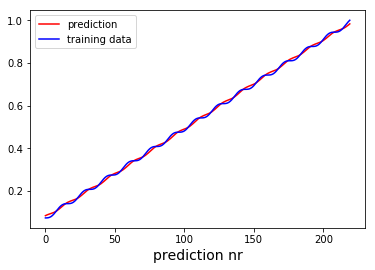

prediction_errors= [0.01 0.01 0.02 0.02 0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.01 0.
 0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.01
 0.01 0.01 0.   0.   0.   0.01 0.01 0.01 0.01 0.   0.   0.   0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.01 0.   0.   0.
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.01 0.
 0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.01 0.01 0.01
 0.01 0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.01
 0.01 0.01 0.01 0.01 0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.   0.
 0.   0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.01 0.01 0.01
 0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.01 0.01 0.01
 0.01 0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.
 0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.
 0.   0.   0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.   0.   0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.01

In [128]:
prediction = model.predict(train_input_reshaped)
print("prediction has shape", prediction.shape)
print("train_output has shape", train_output.shape)
#print(prediction)


plt.plot(prediction, label="prediction", color="red")
plt.plot(train_output, label="training data", color="blue")
plt.xlabel("prediction nr", fontsize=14)
plt.legend()
plt.show()


prediction_errors = \
   np.abs(prediction.reshape(prediction.shape[0]) - train_output)
mean_prediction_error = np.mean(prediction_errors)
print("prediction_errors=", prediction_errors)
print("mean_prediction_error=", mean_prediction_error)


## 6. Experiments regarding LOOK_BACK and NR_TRAIN_EPOCHS

#### Experiment #1:
Try LOOK_BACK=3 and NR_TRAIN_EPOCHS=500:<br>
You can see that the overall form of the predicted curve is ok, but the amplitude
and the phase is not correct<br>
mean prediction error: 0.14

#### Experiment #2:
Try LOOK_BACK=3 and NR_TRAIN_EPOCHS=1500:<br>
mean prediction error: 0.03

#### Experiment #3:
Try LOOK_BACK=6, MORE_DATA=5.0 and NR_TRAIN_EPOCHS=1500:<br>
mean prediction error: 0.01


#### Experiment #4:
Try LOOK_BACK=6, MORE_DATA=5.0, NR_TRAIN_EPOCHS=1500, SCALE_TIME_SERIES =False:<br>
The LSTM model always predicts the same value which corresponds to the mean of the data!
   
#### Experiment conclusions:

- Exp #2 shows: more training epochs help
- Exp #3 shows: more data helps



## 7. Long-term predictions

In the previous experiment we always took LOOK_BACK many values and predicted the next value. E.g., we have the sales figures for the last LOOK_BACK=5 days and we want to predict the sales figures for the next day.

However, in some applications we would like to do long-term predictions. E.g., we have just LOOK_BACK=5 sales figures of the last 5 days and we want to predict the sales figures for the next two weeks.

What can we do? We could use our predicted values as input for the next prediction round!

First prediction round:

    sales_t-5, sales_t-4, sales_t-3, sales_t-2, sales_t-1 --> pred_sales_t

Second prediction round:

    sales_t-4, sales_t-3, sales_t-2, sales_t-1, pred_sales_t --> pred_sales_t+1

Third prediction round:

    sales_t-3, sales_t-2, sales_t-1, pred_sales_t, pred_sales_t+1 --> pred_sales_t+2
    
...

Let's try this approach!

### Making a single prediction

First we need to learn how to do a single prediction. Then we can prepare the input data in each new prediction step such that we include the last prediction values.

In [129]:
# 1. Prepare training data such that we can use
#    LOOK_BACK many last time steps for the prediction
print("LOOK_BACK is", LOOK_BACK)
train_input, train_output = split_into_train_samples( time_series, LOOK_BACK)

# 2. Prepare input for a single prediction
single_input = np.array( [time_series[i] for i in range(0,LOOK_BACK)] )
# LSTM expects input to be [samples, time steps, features]
single_input_reshaped = single_input.reshape(1,LOOK_BACK,1)
single_prediction = model.predict(single_input_reshaped)
ground_truth = time_series[LOOK_BACK]
print("single_prediction has type", type(single_prediction))
print("single_prediction=", single_prediction[0][0])
print("ground_truth=", ground_truth)


LOOK_BACK is 20
single_prediction has type <class 'numpy.ndarray'>
single_prediction= 0.08365065
ground_truth= 0.07308656045768107


### Using predicted values as input for the next prediction step

Now we want to follow the idea mentioned above and put the predicted value into the input vector for the next prediction step.

I will now try a long term prediction for 220 time steps.
Thereby I will use each predicted value for the next input.


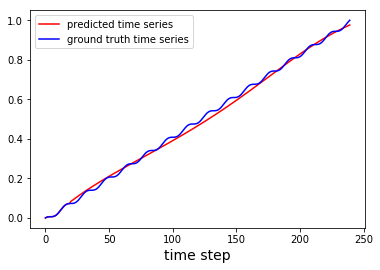

Len of predicted_time_series is 240
Len of time_series is 240
prediction_errors= [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.01 0.01 0.01 0.01 0.   0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.03 0.02
 0.02 0.02 0.01 0.01 0.01 0.   0.   0.   0.   0.01 0.01 0.01 0.02 0.02
 0.02 0.02 0.02 0.01 0.01 0.   0.   0.   0.01 0.01 0.   0.   0.   0.01
 0.01 0.01 0.01 0.01 0.01 0.   0.   0.01 0.01 0.01 0.02 0.02 0.01 0.01
 0.01 0.   0.   0.   0.   0.   0.   0.01 0.01 0.02 0.02 0.02 0.03 0.03
 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.02 0.02 0.02 0.01 0.01 0.01 0.02 0.02 0.03 0.03
 0.03 0.04 0.04 0.04 0.03 0.03 0.03 0.02 0.02 0.02 0.01 0.02 0.02 0.02
 0.02 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.02 0.02 0.01 0.01 0.01 0.01
 0.01 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.02 0.02 0.02 0.01 0.01 0.
 0.   0.   0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.
 0

In [130]:
NR_PREDICTION_STEPS = len(time_series)-LOOK_BACK
print("I will now try a long term prediction for",
      NR_PREDICTION_STEPS, "time steps.")
print("Thereby I will use each predicted value "
      "for the next input.")

# 1.
# For the very first prediction vector
# we need some input data:
# here we take the first LOOK_BACK time steps
# from the ground truth data
predicted_time_series = [time_series[i] for i in range(0,LOOK_BACK)]

# 2. 
# now lets predict a new value for each coming
# time step based on past predicted values
for prediction_step in range(0,NR_PREDICTION_STEPS):

    # 2.1 
    # prepare the last LOOK_BACK values of the predicted
    # time series as input vector for the next prediction
    N = len(predicted_time_series)
    single_input_as_np_array =\
       np.array( predicted_time_series[N-LOOK_BACK:N] )
    #print(single_input_as_np_array)
    
    # 2.2
    # LSTM expects input to be 3D dimensional!
    # It shall have the shape: [samples, time steps, features]
    single_input_reshaped = single_input_as_np_array.reshape(1,LOOK_BACK,1)
    single_prediction = model.predict(single_input_reshaped)
    
    # 2.3
    # get the predicted value as a scalar
    # Note: Keras provides us the prediction as a 2D NumPy matrix
    #       - for each input vector a prediction row
    #       - for each of the predicted values a column
    predicted_value = single_prediction[0][0]
    #print("predicted_value=", predicted_value)
    
    # 2.4
    # save the predicted value
    predicted_time_series.append( predicted_value )
    
    
# 3.
# plot the predicted time series and
# the ground truth time series for comparison    
plt.plot(predicted_time_series, label="predicted time series", color="red")
plt.plot(time_series, label="ground truth time series", color="blue")
plt.xlabel("time step", fontsize=14)
plt.legend()
plt.show()


# 4.
# now compute the difference between predicted values
# and ground truth values
print("Len of predicted_time_series is", len(predicted_time_series))
print("Len of time_series is", len(time_series))
prediction_errors = np.abs(np.array(predicted_time_series) - np.array(time_series))
mean_prediction_error = np.mean(prediction_errors)
print("prediction_errors=", prediction_errors)
print("mean_prediction_error=", mean_prediction_error)    
    
    


## 8. Experiments with long-term predictions

Set EXP_NR=5 and observe the resulting predicted time series:<br>
It has predicted the overall increasing trend of the time series, but the exact values are bad.

Set EXP_NR=6 and observe the resulting predicted time series:<br>
It has predicted the overall increasing trend of the time series and the predicted values are much better.
